## Computer Vision

In [61]:
import torch
from torch import nn
import torchvision

- `torch` main pytorch
- `torchvision` for computer vision libraryb
- `torchvision.dataset` get dataset and data loading function for computer vision
- `torchvision.models` get pretrained computer vision models that we can use for our own problems that we want to solve
- `torchvision.transforms` function for manipulating image data
- `torch.utils.data.Dataset` for base dataset class for pytorch
- `torch.utils.data.DataL0ader` data loader


In [62]:
print(torch.cuda.is_available())

True


In [63]:
!nvidia-smi

Tue Oct  8 18:24:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [65]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

## Getting dataset
Fashion MNIST dataset.

In [66]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True, # training version of dataset, if false get test data
    download=True, # download the data
    transform=ToTensor(), # transform to tensor
    target_transform=None # transform the label?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [67]:
len(train_data), len(test_data)

(60000, 10000)

In [68]:
# see the train example

image, label = train_data[0]
print(image.shape, label)
# [1, 28, 28]
# 1 color channel, 28 * 28 width * height

torch.Size([1, 28, 28]) 9


In [69]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [70]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [71]:
image.shape # CHW

torch.Size([1, 28, 28])

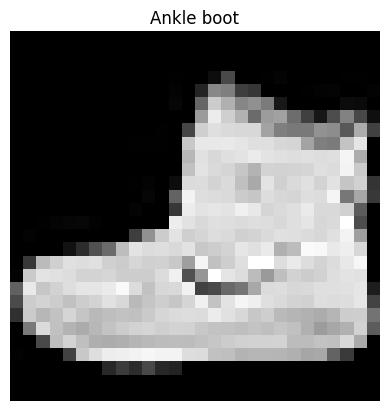

In [72]:
# visualize the data

# expect h*w for grayscale and color channel last
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("off")
plt.show()

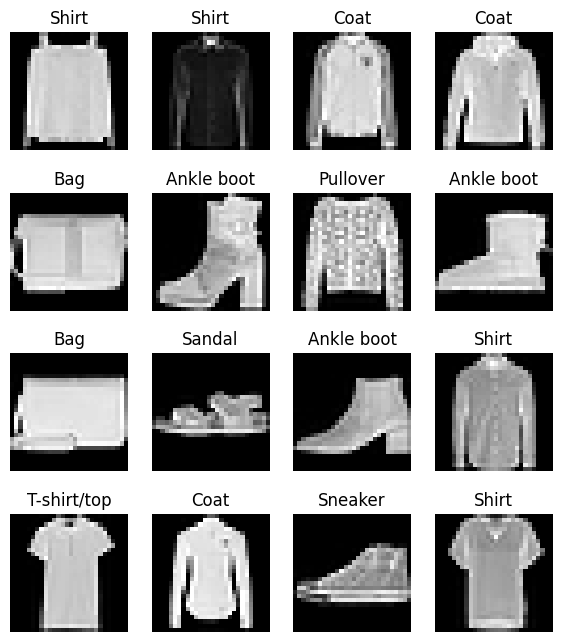

In [73]:
# visualize random group of image
fig = plt.figure(figsize=(7,8))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_index = torch.randint(0, len(train_data), size=[1]).item() # get scalar out of single tensor
  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis("off")

plt.show()

### DataLoader

In [74]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [75]:
# dataloader turn dataset into python iterable
from torch.utils.data import DataLoader

# define batch size
BATCH_SIZE = 32

# turn into iterables (batch size 32)
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [76]:
print(f"DataLoader: {train_dataloader}\n")
print(f"Length of train dataloader {len(train_dataloader)} batches of 32")
# 1875 * 32

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x78c47cb19cc0>

Length of train dataloader 1875 batches of 32


In [77]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

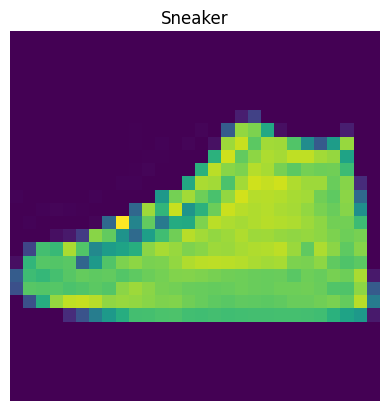

In [78]:
randomId = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[randomId], train_labels_batch[randomId]
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis("off")
plt.show()

## Building a model: Model 0

In [79]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

print("Before flatten", x.shape) # Color, Height, Width

output = flatten_model(x)

print("After flatten", output.shape) # Color, Height * Width

Before flatten torch.Size([1, 28, 28])
After flatten torch.Size([1, 784])


In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [81]:
from torch import nn

class FashionMNISTModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int
               ):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [82]:
model_0 = FashionMNISTModel0(
    input_shape=784, # 28*28
    hidden_units=10,
    output_shape=len(class_names)
).to("cuda")
model_0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [83]:
dummy = torch.rand([1, 1, 28, 28]).to(device)
dummy.shape

torch.Size([1, 1, 28, 28])

In [84]:
model_0(dummy)

tensor([[-0.3257, -0.2047, -0.0229,  0.4017, -0.1253,  0.3996,  0.1228,  0.4289,
          0.0052, -0.2325]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [85]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [86]:
import requests

helper_file = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(helper_file.content)

In [87]:
from helper_functions import accuracy_fn

In [88]:
# experiment tracking function
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  """print time taken by model"""
  total_time = end - start
  print(f"Time on {device}: {total_time} seconds")
  return total_time

In [89]:
start_time = timer()

end_time = timer()

print_train_time(start_time, end_time, device=device)

Time on cuda: 4.9880999540619086e-05 seconds


4.9880999540619086e-05

## Training Loop

In [90]:
# 1. Loop
# 2. Train batch, perform train loss per batch
# 3. Test batch, perform test loss per batch
# 4. Print out what is happening in our code
# 5. Time it

from tqdm.auto import tqdm

train_time_start_gpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # training
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):
    # forward propagation
    model_0.train()
    # output
    y_pred = model_0(X.to(device))
    # loss calculation
    loss = loss_function(y_pred, y.to(device))
    # accumulating loss for the batch
    train_loss += loss
    # zero gradient
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # Gradient descent optimizer
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
  # train loss in a batch
  train_loss = train_loss / len(train_dataloader)
  ## test
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # forward
      test_pred = model_0(X_test.to(device))
      # loss calc
      test_loss = test_loss + loss_function(test_pred, y_test.to(device))
      # acc calc
      test_acc = test_acc + accuracy_fn(y_true=y_test.to(device), y_pred=test_pred.argmax(dim=1))
    # loss average per batch
    test_loss = test_loss / len(test_dataloader)
    # test accuracy per batch
    test_acc = test_acc / len(test_dataloader)

  print(f"Train loss: {train_loss} : Test loss: {test_loss} : Test acc: {test_acc}")

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(
    start = train_time_start_gpu,
    end = train_time_end_on_gpu,
    device = device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.5910192728042603 : Test loss: 0.515888512134552 : Test acc: 81.88897763578275
Epoch: 1
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.47982773184776306 : Test loss: 0.5133932828903198 : Test acc: 81.36980830670926
Epoch: 2
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.457013338804245 : Test loss: 0.5086432695388794 : Test acc: 81.8091054313099
Epoch: 3
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.44428950548171997 : Test loss: 0.4505

## Prediction

In [91]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # prediction on test data
      y_pred = model(X.to(device))
      # loss and accuracy per batch
      loss = loss + loss_fn(y_pred, y.to(device))
      acc = acc + accuracy_fn(y_true=y.to(device), y_pred=y_pred.argmax(dim=1))
    loss = loss / len(data_loader)
    acc = acc / len(data_loader)
  return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_acc": acc}

In [92]:
# eval model_0

model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_function,
    accuracy_fn=accuracy_fn
)
print(f"Model 0 results: {model_0_results}")

Model 0 results: {'model_name': 'FashionMNISTModel0', 'model_loss': 0.4623141586780548, 'model_acc': 83.77595846645367}


## Model_1

In [93]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78c47cb19cc0>,
 <torch.utils.data.dataloader.DataLoader at 0x78c47cb1a560>)

In [94]:
device

'cuda'

In [95]:
class FashionMNISTModel1(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_1 = FashionMNISTModel1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1

FashionMNISTModel1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

## Train and Test  

In [103]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    # converting to device type
    X, y = X.to(device), y.to(device)
    # forward progagation
    y_pred = model(X)
    # loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss
    # accuracy calculation
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    # backward calculation
    loss.backward()
    # optimizer
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  print(f"train_loss {train_loss},train_acc: {train_acc}")


def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):

  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)
  print(f"test_loss {test_loss}, test_acc {test_acc}")


In [104]:
from timeit import default_timer as timer
train_time_start_on_gpu = timer()
epochs = 3

for epoch in tqdm(range(epoch)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  test_step(model=model_1,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()

0it [00:00, ?it/s]

In [107]:
model_1

FashionMNISTModel1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)